In [178]:
import numpy as np
import matplotlib.pyplot as plt

from stacked_mnist import StackedMNISTData, DataMode

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

from utils import *

In [179]:
# Using the provided mnist dataset class
gen = StackedMNISTData(mode=DataMode.MONO_BINARY_COMPLETE, default_batch_size=9)

train_data = gen.get_full_data_set(training=True)
test_data = gen.get_full_data_set(training=False)

In [180]:
train_data[0].shape, test_data[0].shape

((60000, 28, 28, 1), (10000, 28, 28, 1))

(60000, 28, 28, 1) (60000,)
(10000, 28, 28, 1) (10000,)
(28, 28, 1)


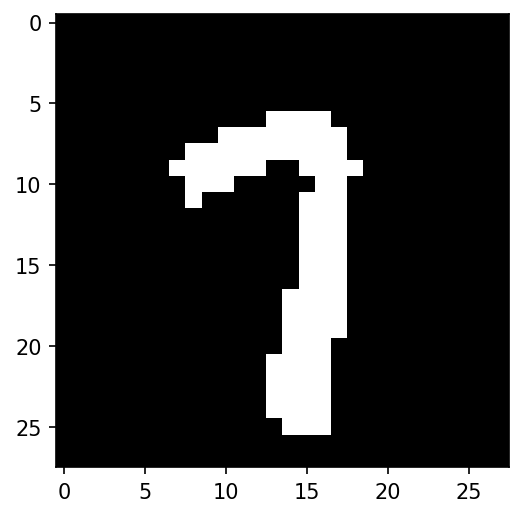

In [181]:
x_train, y_train = train_data
x_test, y_test = test_data
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

# Convert y_train and y_test into one-hot vectors
y_train = to_one_hot(y_train)
y_test = to_one_hot(y_test)

img = x_train[np.random.randint(0, x_train.shape[0])]
print(img.shape)

plt.figure(figsize=(6, 4), dpi=150)
plt.imshow(img, cmap="gray")

In [182]:
# Create Pytorch Image Classifier Model

class MNISTClassifier(nn.Module):
    def __init__(self, image_depth=1):
        super(MNISTClassifier, self).__init__()

        self.feature_extractor = nn.Sequential(
            nn.Conv2d(image_depth, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(7 * 7 * 32, 128),
            nn.ReLU(),
            nn.Linear(128, 10),
        )

    def forward(self, x):
        x = self.feature_extractor(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [183]:
# Create pytorch dataloaders from x_train and y_train
x_train = torch.from_numpy(x_train.astype(np.float32)).permute(0, 3, 1, 2)
y_train = torch.from_numpy(y_train.astype(np.float32))

train_dataset = TensorDataset(x_train, y_train)
train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)

# Create pytorch dataloaders from x_test and y_test
x_test = torch.from_numpy(x_test.astype(np.float32)).permute(0, 3, 1, 2)
y_test = torch.from_numpy(y_test.astype(np.float32))

test_dataset = TensorDataset(x_test, y_test)
test_loader = DataLoader(dataset=test_dataset, batch_size=32)

In [184]:
# Training setup
model = MNISTClassifier(image_depth=1)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
criterion = nn.CrossEntropyLoss()

# Training loop

for epoch in range(20):
    model.train()
    total_loss = 0
    for images, labels in train_loader:
        images.squeeze(0)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch} loss: {total_loss}")




Epoch 0 loss: 408.9386843123939
Epoch 1 loss: 124.04664756933926
Epoch 2 loss: 87.49189082885277
Epoch 3 loss: 62.51715957986016
Epoch 4 loss: 50.096826777094975
Epoch 5 loss: 36.621041059519484
Epoch 6 loss: 30.83946824701343
Epoch 7 loss: 22.32738084204493
Epoch 8 loss: 18.863923184569103
Epoch 9 loss: 16.452881228024125
Epoch 10 loss: 12.9782811803056
Epoch 11 loss: 11.980791888657109
Epoch 12 loss: 9.072848177981257
Epoch 13 loss: 8.75932927937091
Epoch 14 loss: 8.11296191296855
Epoch 15 loss: 7.707642289688025
Epoch 16 loss: 6.7924239597355704
Epoch 17 loss: 6.280734847431663
Epoch 18 loss: 5.790490434832652
Epoch 19 loss: 5.2836151796693045


In [186]:
model.eval()

with torch.no_grad():
    correct_preds = 0
    test_loss = 0
    for x, y in test_loader:
        pred = model(x)
        loss = criterion(pred, y)
        test_loss += loss.item()

        pred = pred.argmax(dim=1, keepdim=True)
        truth = y.argmax(dim=1, keepdim=True)
        correct_preds += pred.eq(truth.view_as(pred)).sum().item()
        

    test_accuracy = correct_preds / len(test_loader.dataset)

print(f"Test loss: {test_loss}")
print(f"Test accuracy: {100*test_accuracy}%")


Test loss: 18.827587355025393
Test accuracy: 98.91%
